# Neural Networks

In [1]:
# Import some helper functions (please ignore this!)
from utils import *

**Context:** So far, we've focused on translating our IHH colleague's goals into probabilistic models, and then fitting these models to data to help them answer scientific questions. In each model's conditional distributions, we've had to make two choices: what distribution to use, and how the distributions parameter should depend on the condition. For example, in regression, recall we picked the following conditional distribution:
\begin{align}
p_{Y | X}(\cdot | x_n; \underbrace{W, \sigma}_{\theta}) = \mathcal{N}( \underbrace{\mu(x_n; W)}_{\text{trend}}, \underbrace{\sigma^2}_{\text{noise}} ),
\end{align}
where $\mu(x_n; W)$ represents the "trend" of the data. We've had to decide whether $\mu(x_n; W)$ should be linear, polynomial, or some other function. As our data grows in complexity---for example, as $x_n$ becomes high-dimensional---it becomes increasingly difficult to make up functions that are, expressive, fast, and easy to code. We will show you why below. 

**Challenge:** So what functions should be use in our probabilistic models? Here, we will introduce a new type of function---a *neural network*. As we will show here, neural networks are expressive, fast, and easy to code. 

**Outline:** 
* Shortcomings of other expressive functions, likely polynomials
* The idea behind neural networks: using function composition to create expressive functions
* Introduce *a little bit* of linear algebra to help introduce neural networks
* Introduce neural networks, implement them in `NumPyro` and fit them to IHH data
* Connect the math behind neural networks to the pictures used to represent them in popular media

## The Shortcomings of Polynomials

**The Universality of Polynomials.** In both chapters about regression and classification, we observed the benefits of using non-linear functions for data with non-linear trends. In regression, we've focused on polynomials as our primary tool for creating non-linear functions, and for our low-dimensional data, they seemed to work great! So you may be wondering, why not apply them to high-dimensional data as well? In fact, polynomials boast a very powerful property: they are *universal function approximators*. By this, we mean that for any continuous function on some bounded interval $[a, b]$, we can find a polynomial that approximates it arbitrarily well (this is known as the [Stone–Weierstrass theorem](https://en.wikipedia.org/wiki/Stone%E2%80%93Weierstrass_theorem)). This means that for *any* data set that consists of continuous trends, *theoretically speaking*, polynomials can capture it. This is a huge deal! So let's see how polynomials measure up against a neural network:

```{figure} _static/figs/example_regression_inductive_bias_percent_ood_0.png
---
name: fig-regression-inductive-bias-closeup
align: center
---
Examples of polynomial and neural network regression on IHH data.
```

As you can see, polynomial regression seems to capture the trend in these regression data sets super well---so why aren't they as famous as neural networks? Polynomial regression actually comes with several challenges that make it inappropriate in many contexts. 

**Challenge 1: Numerical Instability.** Polynomials are numerically unstable. Imagine you want to use a degree-20 polynomial in your regression model. This means that, in fitting your model, you will have to evaluate $x^20$. When $x = 0.1$ and when $x = 10.0$, you're asking your computer to represent numbers like $0.000000000000000000001$ and $1000000000000000000000$. Because your computer only has finite precision, very small numbers are at risk of being rounded down to $0$ and very large numbers may overflow. 

**Challenge 2: Inductive Bias.** Oftentimes, we're less interested in seeing what our model does on data we've already observed. Instead, we want to know what it might do for a *new* data point. For example, suppose we're asked to develop a model to predict telekinetic ability and glow from age (like we did in the regression chapter). We aren't interested in seeing the model's predictions on patients included in our data set---we've already observed these patients' age, telekinetic ability, and glow. What we're we're interested in is the model's predictions for *new* patients. For example, what happens if we get an input that we've never seen before, like a patient that's much older or younger than the rest of the patients in the data.

We call the trend of the model away from the data its "inductive bias." Different models that fit the data equally well may actually have different inductive biases. Let's illustrate what we mean visually. In the plot above, you see that the 5th and 6th-degree polynomials both fit the data equally well. But what would they predict for points away from our data? And will their predictions be medically reasonable? Let's have a look: the plot below shows the very same models from the plot above, but this time the plots are zoomed out. In this way you can see each model's behavior away from the data. As you can see, each model's inductive bias is different.

```{figure} _static/figs/example_regression_inductive_bias_percent_ood_30.png
---
name: fig-regression-inductive-bias
align: center
---
A zoomed-out plot of the same models from the figure above.
```

What's interesting in the above plot is that the polynomial regression's inductive bias tends towards positive or negative infinity very quickly. Looking at the math, this makes sense: a 5th or 6th-degree polynomial will include terms like $\text{age}^5$, which grow quickly with age.

While this may be the desired behavior for some data sets, for our data sets, it's inappropriate. For example, look at the left-middle plot, in which the 5th-degree polynomial regression predicts telekinetic ability from age. Even though we've generally seen that as age increases, telekinetic ability decreases, this plot suggests the opposite. After age 100, the patient's telekinetic ability *skyrockets*; in fact, it increases so quickly it's larger than the ability of all other patients. While in comparison, the neural network's inductive bias doesn't seem obviously inappropriate, that doesn't mean that it is appropriate. It's important to remember that neural networks, like any other function, have inductive biases that are useful for *some* tasks and not for others.

**Conclusion:** When picking a function-class to work with (like the class of polynomials), it's important to consider numerical stability (as well as ease of optimization). Without these properties, it doesn't matter how expressive your function is, since you'll never be able to practically fit it to data. Second, it's important to think about the function class's inductive bias, or in other words, to think about how it will generalize in regions of the space where data is scarce. 

## Expressive Functions from Simple Building Blocks

**Idea.** Instead of using polynomials, let's see if we can build an expressive function-class, $\mu(\cdot; W)$, from small building blocks. Each block will be simple and numerically stable. And when combined, will give us an expressive function, capable of adapting to any trend we observe in the data. This is the mechanism underlying neural networks.

Let's import some libraries so we can plot as we go.

In [2]:
import jax.numpy as jnp
import jax.random as jrandom
import jax.nn as jnn
import numpyro.distributions as D

**A Simple Block.** For the simple block, let's use a sigmoid. A sigmoid looks like a smoothed-out step function:

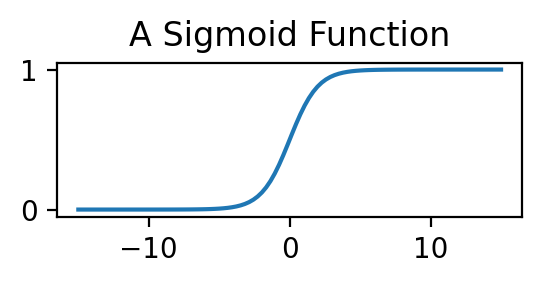

In [3]:
plt.figure(figsize=(3, 1))

# Domain on which to visualize our functions
x = jnp.linspace(-15.0, 15.0, 100)

# Plot the sigmoid
plt.plot(x, jnn.sigmoid(x))

plt.title('A Sigmoid Function')
plt.show()

We will give the sigmoid two parameters, which we will learn from data, giving us our simple building block:
\begin{align}
u(x; w, b) &= \mathrm{sigmoid}( \underbrace{w \cdot x + b}_{\text{horizontal scale and shift}} )
\end{align}
Here, $b$ shifts the sigmoid left/right, and $w$ stretches/shrinks the overall sigmoid horizontally. Let's see what this looks like for different choices of choices of $w$ and $b$:

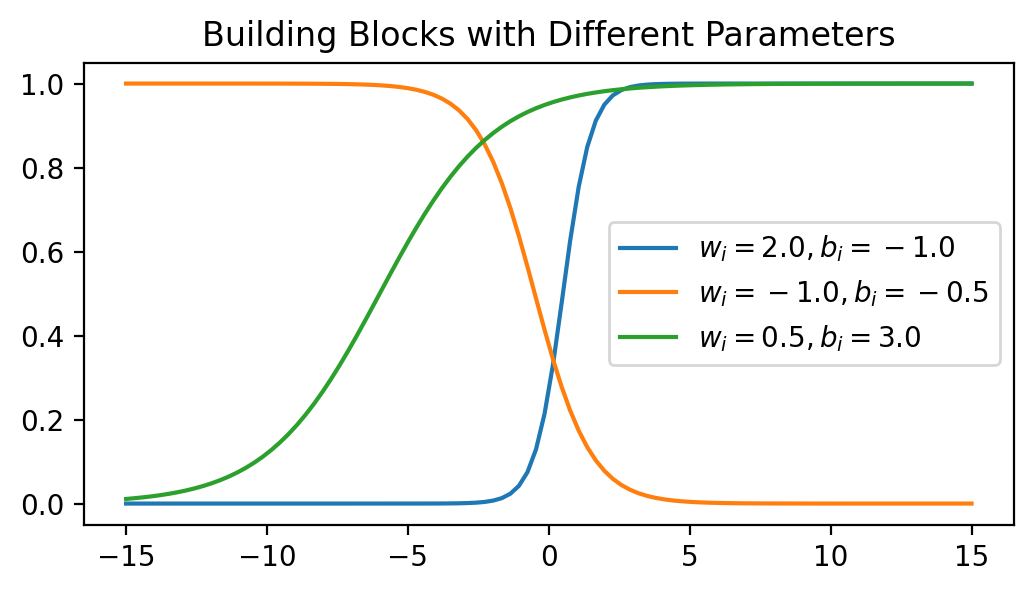

In [4]:
# Choose some scales and shifts
scale = [2.0, -1.0, 0.5]
shift = [-1.0, -0.5, 3.0]

# Plot!
plt.figure(figsize=(6, 3))

# Domain on which to visualize our functions
x = jnp.linspace(-15.0, 15.0, 100)

# For each set w, b plot the function
for w, b in zip(scale, shift):
    plt.plot(x, jnn.sigmoid(w * x + b), label=r'$w_i = {}, b_i = {}$'.format(w, b))
    
plt.title('Building Blocks with Different Parameters')
plt.legend()
plt.show()

Of course, the above example is only for a 1-dimensional input. Ideally, our function class will work for higher-dimensional inputs. We can incorporate this into our simple block as follows. We define $D_x$ to be the dimension of the inputs, $x$, and we sum over the scaled and shifted inputs as follows:
\begin{align}
u(x; w, b) &= \mathrm{sigmoid}\left( \sum\limits_{d=1}^D \underbrace{w_d \cdot x^{(d)} + b_d}_{\text{horizontal scale and shift}} \right)
\end{align}
where $x^{(d)}$ denotes the $d$-th dimension of $x$, and $w = \{ w_1, \dots w_d \}$ and $b = \{ b_1, \dots b_d \}$ have a different scale and shift for every dimension.

This unassuming building block, $u(x; w, b)$, is actually called a *neuron*. We will next start combining these neurons to form a full neural network. 

**Combining Building Blocks via Addition.** As we've seen when plotting our building block (or neuron), it can't really model anything too interesting. However, by adding these neurons together with different parameters, we can start making more interesting-looking functions. To get some intuition, let's start with a simple experiment---we'll add the three neurons from the plot above and see what kind of function we get:

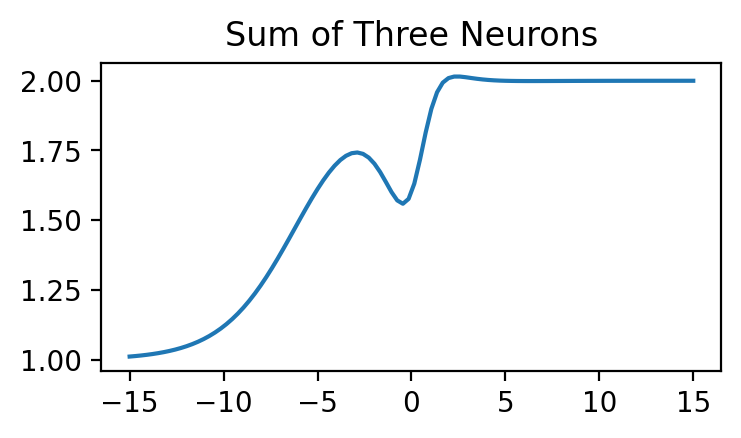

In [5]:
# Domain on which to visualize our functions
x = jnp.linspace(-15.0, 15.0, 100)

# Compute the sum of the blocks
y = 0.0
for w, b in zip(scale, shift):  
    y += jnn.sigmoid(w * x + b)

# Plot!
plt.figure(figsize=(4, 2))
plt.plot(x, y)
plt.title('Sum of Three Neurons')
plt.show()

As you can see, this function already looks a lot more interesting than a sigmoid on its own. Now, let's formally decide how to combine neurons into a function.

Recall that a sigmoid always outputs a value in $[0, 1]$. Because of this, $u(\cdot; w, b)$ will also only output values in $[0, 1]$. To represent functions outside of this limited range, we will apply a scale and shift like before, and then sum over a group of $H$ of these neurons:
\begin{align}
f(x; W, b) &= \sum\limits_{h=1}^H \underbrace{w_h^\text{out} \cdot u(x; w_h^\text{in}, b_h^\text{in}) + b_h^\text{out}}_{\text{vertical scale and shift}}
\end{align}
where 
\begin{align}
W &= \{ w_1^\text{in}, \dots, w_H^\text{in}, w_1^\text{out}, \dots, w_H^\text{out} \} \\
b &= \{ b_1^\text{in}, \dots, b_H^\text{in}, b_1^\text{out}, \dots, b_H^\text{out} \}
\end{align}

So what kind of functions can be captured by $f(\cdot; W, b)$? 
1. Let's plot functions composed of $H = 10$ neurons.
2. So that we don't have to pick values of $W$ and $b$ by hand, let's draw them from some distribution. Here, we'll go with a Normal distribution.
3. We'll repeat the process $N$ times to get a sense of the variety of functions $f(\cdot; W, b)$ can represent.

Let's see what happens:

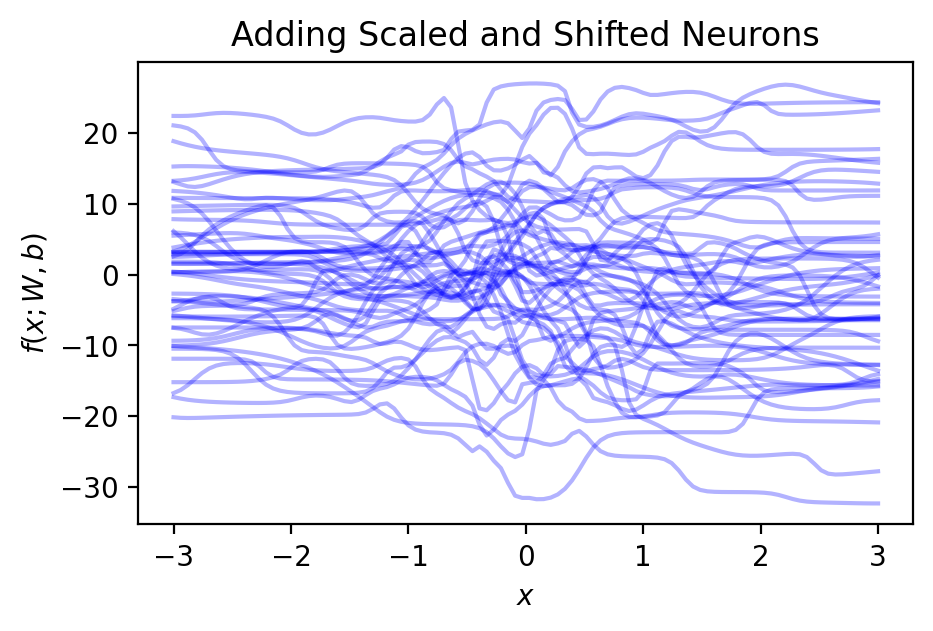

In [16]:
# Number of building blocks to add
H = 30

# Number of functions to plot
N = 50

# Domain on which to visualize our functions
x = jnp.linspace(-3.0, 3.0, 100)

# Create one random key per function
key = jrandom.PRNGKey(seed=0)
key_per_function = jrandom.split(key, N)

plt.figure(figsize=(5, 3))

for k in key_per_function:
    key_W_in, key_W_out, key_b_in, key_b_out = jrandom.split(k, 4)

    # Generate the parameters of the block from a Normal distribution
    W_in = D.Normal(0.0, 20.0).sample(key_W_in, (H, 1))
    b_in = D.Normal(0.0, 20.0).sample(key_b_in, (H, 1))

    W_out = D.Normal(0.0, 3.0).sample(key_W_out, (H, 1))
    b_out = D.Normal(0.0, 1.0).sample(key_b_out, (H, 1))

    # Use some "broadcasting" magic to efficiently sum the building blocks
    f = (W_out * jnn.sigmoid(W_in * x + b_in) + b_out).sum(axis=0)
    
    # Plot!
    plt.plot(x, f, alpha=0.3, color='blue')

plt.xlabel(r'$x$')
plt.ylabel(r'$f(x; W, b)$')
plt.title('Adding Scaled and Shifted Neurons')
plt.show()

Now we're getting wiggly! Given how many different functions $f(\cdot; W, b)$ can represent, you can imagine that by learning the parameters, $W$ and $b$, from data, we can capture the data trends accurately. Moreover, notice that, unlike polynomials, there's nothing about $f(\cdot; W, b)$ that is numerically unstable. Each neuron is a sigmoid, so its range is between $[0, 1]$; therefore, summing up the sigmoids together to get $f(\cdot; W, b)$ doesn't blow up like a polynomial.

The function we arrived at, $f(\cdot; W, b)$, is called a *neural network* (of "width" $H$. We can plug it into our regression or classification models and learn the parameters, $\theta = \{ W, b \}$, via MLE. 

**Combining Building Blocks via Composition.** We can make the neural network we've created so far *even more expressive* using function composition, meaning we apply a function to the output of another function. Composing neural networks means:
1. Taking a collection of neural networks, $f_1, \dots, f_L$, each with different parameters.
2. Evaluating each neural network on some input $x$, giving us an $L$-dimensional array of intermediate values, $I$.
3. Treating every intermediate $I$ as our new input (i.e. the new $x$), which we will feed into another collection of neural networks, repeating the process.

Every repetition of this process adds another "layer" to the neural network, making it "deeper"---the number of layers is known as the depth of the network.

We won't notate all of this with math, because it gets cumbersome unless we introduce some additional notation (this is what we'll do next). You can imagine though, the deeper the network, the more expressive it will be.

**Activation Functions.** Here, we chose to use a sigmoid in our neuron. There are many functions we could have used instead, each giving us different neural networks with different inductive biases. These functions are generally called "activation functions." [Wikipedia](https://en.wikipedia.org/wiki/Activation_function) organized a table of them, and many of them are already implemented in `Jax` (see [here](https://jax.readthedocs.io/en/latest/jax.nn.html#activation-functions)). 

The name "activation function" comes from the inspiration from neuroscience that led to neural networks. 

```{figure} https://www.researchgate.net/profile/Xianlin-Wang/publication/351372032/figure/fig4/AS:1020744041525248@1620375752492/Comparison-between-biological-neuron-and-artificial-neuron-40.png
---
width: 500px
name: artificial-vs-biological-neuron
align: center
---

Inspiration behind the "neuron" in a neural network. Figure taken from [this paper](https://www.sciencedirect.com/science/article/abs/pii/S2352012421003179).
```

As you can see from the figure, each neuron takes signals from its inputs (by summing over the scaled and shifted inputs). The sum is then passed on to the activation function, which only "activates" (or sends a non-zero value) if the sum is sufficiently large. Looking at the shape of the sigmoid activation function, for example, you can see exactly the input value for which the sigmoid would output a non-zero value. You can learn more about the connection between artificial and biological neurons [here](https://s.mriquestions.com/what-is-a-neural-network.html).

## Efficient Representations via Matrices

So how can we code a neural network in a way that's (a) easy to code, and (b) efficient for the computer to evaluate? We'll now use some tricks from linear algebra---matrices---to help us out. Considerable [research and engineering](https://en.wikipedia.org/wiki/Computational_complexity_of_matrix_multiplication) has gone into allowing your computer to multiply matrices fast. By relying on this prior work, we can implement our neural networks easily and efficiently. If you haven't taken linear algebra before, that's no problem. We'll walk you through exactly the parts you need to know to implement your own neural network. 

**What's a Matrix?** For our purposes, you can think of a matrix as a 2-dimensional array. Here are some examples of matrices:

```{figure} _static/figs/matrices.jpg
---
width: 400px
name: matrices
align: center
---

Two matrices, $A$ and $B$, taken from [this website](https://chem.libretexts.org/Courses/Centre_College/CHE_332%3A_Inorganic_Chemistry/03%3A_Molecular_Symmetry_and_Point_Groups/3.03%3A_Properties_and_Representations_of_Groups/3.3.02%3A_Matrices).
```

We say that the matrix $A$ (on the left) is a 2-by-4 matrix, since it has 2 rows and 4 columns. Similarly, the matrix $B$ (on the right) is a 4-by-3 matrix.

**Matrix Multiplication.** To multiply two matrices, we take each row of the first matrix and each column of the second and proceed as follows:

```{figure} _static/figs/matrix-multiplication.jpg
---
width: 400px
name: matrices
align: center
---

Matrix multiplication, $A \cdot B = C$, taken from [this website](https://chem.libretexts.org/Courses/Centre_College/CHE_332%3A_Inorganic_Chemistry/03%3A_Molecular_Symmetry_and_Point_Groups/3.03%3A_Properties_and_Representations_of_Groups/3.3.02%3A_Matrices).
```

As you can see from the figure above, the number of columns in $A$ must match the number of columns in $B$. Moreover, each element $c_{i, j}$ in matrix $C$ represents the following *sum of products*:
\begin{align}
c_{i,k} &= \sum\limits_{j=1}^4 a_{i,j} \cdot b_{j, k},
\end{align}
where $j$ indexes into each element in the row of $A$ *and* the corresponding element in the column of $B$. Next, we'll make the connection between matrices and neural networks.

So why is matrix multiplication defined this way? What are properties of matrices? That's beyond the scope of this course. 

**Sums of Shifted and Scaled Numbers via Matrix Multiplication.** You may have noticed that in our neural network math so far, there's a pattern that keeps popping up. We keep summing over things that we've scaled and shifted. You can see this in the definition of a single neuron, $u(x; w, b)$, in the definition of a simple neural network, $f(x; W, b)$, as well as in the process of creating deeper networks. These sums look very much like the formula for $c_{i,j}$ above. As such, we can represent this operation using *matrix multiplication*.

## Neural Networks

**A 1-Layer Neural Network.** Let $D_x$ be the dimension of our inputs, $x$, and let $D_y$ be the dimension of our outputs, $y$. We can now rewrite our definition of a neural network using matrices. Our neural network will consist of the following recipe:
1. *Scaling the inputs.* We scale each dimension of the inputs, $x$, by $H$ different values. This can be done using a matrix $W_0$ of dimensions $D_x \times H$. This gives us: $x \cdot W_0$. 
2. *Shifting the inputs.* We shift each of the values from the previous steps. This can be done by adding an array/vector, $b_0$ of dimension $H$ to the result from the previous step: $x \cdot W_0 + b_0$. These are our scaled and shifted inputs.
3. *Applying the activation.* We apply an activation function to the result from the previous step. We can use a sigmoid like before, or any other activation function we choose. For generality, we'll call it $g(\cdot)$. This gives us $H$ different neurons: $g(x \cdot W_0 + b_0)$.
4. *Scaling and shifting the outputs.* Recall that we get expressivity by adding scaled and shifted neurons together. To do this, we'll introduce $W_1$ and $b_1$, for scaling and shifting, respectively. $W_1$ has dimensions $H \times D_y$ and $b_1$ has dimensions $D_y$. Altogether, this gives us the following formula:
    \begin{align}
    f(x; \underbrace{W_0, W_1, b_0, b_1}_{\text{parameters, } \theta}) = g(x \cdot W_0 + b_0) \cdot W_1 + b_1.
    \end{align}
    The number of neurons, $H$, is called the *hidden dimension* of the neural network. 

**Deeper Networks.** We can extend the above network by adding as many additional layers as you like:
\begin{align}
    \text{2-layers:} &\quad g( \underbrace{g(x \cdot W_0 + b_0) \cdot W_1 + b_1}_{\text{1-layer neural network}} ) \cdot W_2 + b_2 \\
    \text{3-layers:} &\quad g( \underbrace{g( g(x \cdot W_0 + b_0) \cdot W_1 + b_1) \cdot W_2 + b_2)}_{\text{2-layer neural network}} \cdot W_3 + b_3 \\
    \text{4-layers:} &\quad g( \underbrace{g( g( g(x \cdot W_0 + b_0) \cdot W_1 + b_1) \cdot W_2 + b_2) \cdot W_3 + b_3}_{\text{3-layer neural network}} ) \cdot W_4 + b_4 \\
    &\vdots \\
    \text{$L$-layers:} &\quad \text{do you see the pattern?}
\end{align}
Note that in these neural networks, we always have that:
* The $W$ and $b$ applied to the inputs is always of dimensions $D_x \times H$ and $H$, respectively.
* The $W$ and $b$ applied to the outputs is always of dimensions $H \times D_y$ and $D_y$, respectively.
* The $W$'s and $b$'s in the middle of the network are always of dimension $H \times H$ and $H$, respectively.

````{admonition} Exercise: Neural Network Regression
Load in `data/IHH-CTR-CGLF-regression-augmented.csv`. Your goal is to predict telekinetic ability from age. 

**Part 1:** Take your polynomial regression model, implemented for the chapter on regression. Swap out the polynomial $\mu(\cdot; W)$ with your implementation of a 1-layer neural network. Your neural network implementation should use the matrix formulation above. Use a sigmoid activation function. Please use the following function signature:

```
def model_neural_network_regressor(N, x, y=None, H=20):
    pass # TODO implement
```

Tips:
* To multiply matrices, use `jnp.matmul`---documentation [here](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.matmul.html)). 
* Both your inputs and your outputs should have shape `(N, 1)` for `jnp.matmul` to work correctly. 
* Since you're now passing in data as 2-dimensional arrays, you'll need to use `with numpyro.plate('data', N, dim=-2):` to create your plate. The additional keyword argument `dim=-2` tells `NumPyro` which dimension of the input is `N`. That is, in the tuple, `(N, 1)`, `dim=-2` refers to `N` and `dim=-1` refers to `1`.
* Finally, since neural networks have lots of parameters, it's good to try initializing them to different values when optimizing. Instead of specifying the initial values by hand, like we've done before, follow the template below:
    ```
    W0 = numpyro.param(
        'W0',
        lambda key: 0.1 * jrandom.normal(key, shape=(1, H)), # Initialize to a Gaussian of shape (1, H)
        constraint=C.real,
    )
    ```

**Part 2:** Fit your neural network regression model to the data using MLE using a different number of neurons, $H \in \{2, 16, 32, 64 \}$. For each value of $H$, use 3 different keys (passed into the optimizer)---this, will give you several different initialization, each yielding slightly different fits. 

**Part 3:** Visualize samples from each neural network regression and each initialization against the training data. How does your network behave as you increase $H$? How are the model fits different across different initialization? For both, your answer should look both at how your model interpolates *and* extrapolates (how it fits the data, and what it does away from the data). 

**Part 3:** Replace your activation function with a [ReLU activation](https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.relu.html) and repeat steps (2) and (3). How does this new activation function affect the network's fit?
````

## Types of Neural Networks



## Challenges with Neural Networks